<a href="https://colab.research.google.com/github/goerlitz/nlp-classification/blob/main/notebooks/10kGNAD/colab/FastAIClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classifying News Articles with FastAI ULMFit

We will use the 10k German News Articles dataset to classify 9 news topics.

## Prerequisites

In [1]:
# check installed version
!pip freeze | grep -E "torch|fastai"

fastai==1.0.61
torch==1.8.1+cu101
torchsummary==1.5.1
torchtext==0.9.1
torchvision==0.9.1+cu101


In [2]:
from google.colab import drive
from pathlib import Path
from fastai.text import *
import matplotlib.pyplot as plt
import sklearn.metrics as skm

plt.rcParams['figure.facecolor'] = 'white'

### Mount Google Drive

We will store all model in Google Drive

In [3]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Download Dataset

In [4]:
!mkdir -p data
!wget https://github.com/tblock/10kGNAD/blob/master/train.csv?raw=true -nv -O data/train.csv
!wget https://github.com/tblock/10kGNAD/blob/master/test.csv?raw=true -nv -O data/test.csv
!ls -lAh data

2021-04-20 19:32:47 URL:https://raw.githubusercontent.com/tblock/10kGNAD/master/train.csv [24405789/24405789] -> "data/train.csv" [1]
2021-04-20 19:32:49 URL:https://raw.githubusercontent.com/tblock/10kGNAD/master/test.csv [2755020/2755020] -> "data/test.csv" [1]
total 26M
-rw-r--r-- 1 root root 2.7M Apr 20 19:32 test.csv
-rw-r--r-- 1 root root  24M Apr 20 19:32 train.csv


## Load Dataset

In [5]:
root_path = Path("/content/gdrive/My Drive/Colab Notebooks/nlp-classification/")

model_path = root_path / "model/"
data_path = Path("data/")

train_file = data_path / "train.csv"
test_file = data_path / "test.csv"

In [6]:
def load_file(filepath: Path, columns: list=["labels", "text"]) -> pd.DataFrame:
    """Load dataset from CVS file."""
    f = pd.read_csv(filepath, sep=";", quotechar="'", names=columns)
    return f

In [7]:
train_df = load_file(train_file).assign(is_valid=False)
valid_df = load_file(test_file).assign(is_valid=True)

# combine training and test data
text_df = pd.concat([train_df, valid_df], ignore_index=True)

print(text_df.shape[0], 'articles')
display(text_df.head())

10273 articles


,labels,text,is_valid
0,Sport,21-Jähriger fällt wohl bis Saisonende aus. Wie...,False
1,Kultur,"Erfundene Bilder zu Filmen, die als verloren g...",False
2,Web,Der frischgekürte CEO Sundar Pichai setzt auf ...,False
3,Wirtschaft,"Putin: ""Einigung, dass wir Menge auf Niveau vo...",False
4,Inland,Estland sieht den künftigen österreichischen P...,False


## Explorative Data Analysis

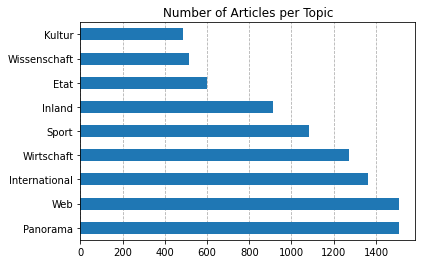

In [8]:
text_df.labels.value_counts().plot.barh(title="Number of Articles per Topic", zorder=2)
plt.gca().xaxis.grid(True, linestyle='--');

In [32]:
def truncate_text(df: pd.DataFrame, column: str, max_length: int) -> pd.DataFrame:
    # df.pipe(lambda x: x.assign(column = x[column].map(lambda x: x[:max_length])))
    df[column] = df[column].map(lambda x: x[:max_length])
    return df

# truncate_text(train_df, "text", 600)

,labels,text,is_valid
0,Sport,21-Jährige,False
1,Kultur,Erfundene,False
2,Web,Der frisch,False
3,Wirtschaft,"Putin: ""Ei",False
4,Inland,Estland si,False
...,...,...,...
9240,Inland,Bernd Saur,False
9241,Internatio,Sandhere s,False
9242,Wirtschaft,Derzeit Ko,False
9243,Inland,Landeshaup,False


## Data Preparation

* load pre-trained language model
* create labeled databunch with vocabulary from language model

In [9]:
# define batchsize
batchsize=32

lm_filepath = root_path / "data" / "10kgnad__lm.pkl"
labeled_filepath = root_path / "data" / "10kgnad__clas.pkl"

### Load Language Model Vocabulary

In [10]:
%%time
# load the language model vocabulary
lm_vocab = load_data(lm_filepath.parent, lm_filepath.name, bs=batchsize).vocab
print(f"{len(lm_vocab.itos):,} words in language model vocabulary")

60,000 words in language model vocabulary
CPU times: user 313 ms, sys: 173 ms, total: 486 ms
Wall time: 3.72 s


### Create Labeled Databunch

In [11]:
def prepare_databunch_labeled(db_path: Path, df: pd.DataFrame, vocab: Vocab, bs: int) -> DataBunch:
    """Load or create text databunch for class labeling task."""

    # check if databunch already exists
    if db_path.is_file():
        print("loading preprocessed text data")
        return load_data(db_path.parent, db_path.name, bs=bs)

    else:
        print("processing text data")
        data_lm = (TextList
                   .from_df(df, cols="text", vocab=vocab)
                   .split_from_df(col='is_valid')
                   .label_from_df(cols="labels")
                   .databunch(bs=bs)
                   )
        data_lm.save(db_path)
        return data_lm

In [12]:
%%time
data_clas = prepare_databunch_labeled(labeled_filepath, text_df, lm_vocab, batchsize)
#data_clas.save(labeled_filepath)

print(f"{len(data_clas.vocab.itos):,} words in vocabulary")

loading preprocessed text data
60,000 words in vocabulary
CPU times: user 2.27 s, sys: 337 ms, total: 2.61 s
Wall time: 3.66 s


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [13]:
data_clas.show_batch(3)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


text,target
"xxbos xxmaj neues xxmaj windows wird seit xxmaj mittwoch als xxmaj download an private xxmaj nutzer verteilt . xxmaj da ist es nun also . xxmaj das erste xxmaj windows unter der xxmaj ägide des neuen xxmaj microsoft - xxmaj chefs xxmaj satya xxmaj nadella . xxmaj und sein xxmaj baby namens xxmaj windows 10 soll nicht nur jene xxmaj nutzer zurückgewinnen , die mit dem zu radikal auf xxmaj",Web
"xxbos "" xxmaj wo sind xxmaj sie daheim ? "" xxmaj diese xxmaj frage war schwer zu beantworten . xxmaj david stach mit dem xxmaj zeigefinger auf seine xxmaj brust und sagte : "" i am from xxmaj syria , i am a masseur , now in xxmaj laa - an - der - xxmaj thaya "" – das ging ihm schon ganz gut von den xxmaj lippen . xxmaj",Panorama
"xxbos xxmaj sticht mit xxmaj mut zu ungewöhnlichem xxmaj design und frischen xxmaj xxunk aus der xxmaj masse heraus . xxmaj es passiert nur selten , dass ein neues xxmaj smartphone in der xxmaj redaktion eintrifft , das wirklich aus der xxmaj masse xxunk . xxmaj scheint es doch fast so , als hätten sich die großen xxmaj hersteller mittlerweile allesamt auf eine gemeinsame xxmaj design - xxmaj linie geeinigt",Web


## Create Classifier for German Articles

In [14]:
!pip install -q wandb > /dev/null

In [15]:
import wandb
from wandb.fastai import WandbCallback

wandb.init(project = "German Classifier ULMFit");

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [16]:
# adapt config for german language model
config = awd_lstm_clas_config.copy()
config['n_hid'] = 1150

In [17]:
from fastai.metrics import accuracy, fbeta, Precision, Recall

learn = text_classifier_learner(data_clas,
                                AWD_LSTM,
                                config=config,
                                drop_mult=0.5,
                                metrics=[accuracy, Precision('macro'), Recall('macro')],
                                callback_fns=WandbCallback
                                )

lm_enc = '10kgnad_fine_tuned_lm_enc'

# file containing encoder of language model
lm_encoder_file = model_path / f'{lm_enc}'

# TODO: find out why we only need the encoder but not the rest of the model
learn.load_encoder(lm_encoder_file);

## Train Model: Top Layer

In [18]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision,recall,time


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:760: UserWarning: Using non-full backward hooks on a Module that does not return a single Tensor or a tuple of Tensors is deprecated and will be removed in future versions. This hook will be missing some of the grad_output. Please use register_full_backward_hook to get the do

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


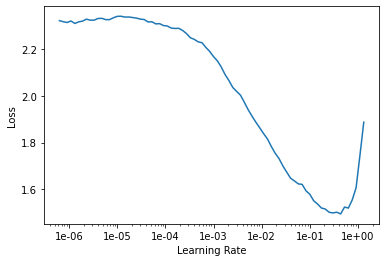

In [19]:
learn.recorder.plot()

In [20]:
learn.fit_one_cycle(2, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,precision,recall,time
0,0.635046,0.505665,0.834630,0.846659,0.824625,06:09
1,0.560313,0.435434,0.849222,0.854009,0.846143,06:18


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Better model found at epoch 0 with valid_loss value: 0.5056653022766113.


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Better model found at epoch 1 with valid_loss value: 0.4354337751865387.
Loaded best saved model from /content/wandb/run-20210420_193333-1o6f3pzg/files/bestmodel.pth


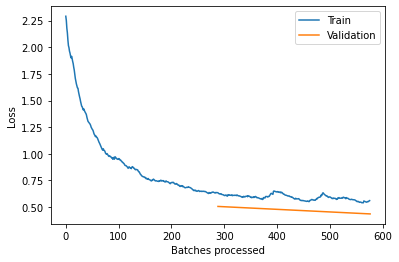

In [21]:
learn.recorder.plot_losses()

In [33]:
learn.save(model_path / f'10gnad__clas_fit_top')

## Train Model: Unfreeze 2 Layers

In [34]:
learn.freeze_to(-2)
learn.fit_one_cycle(3, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,precision,recall,time
0,0.634737,0.518835,0.830739,0.837955,0.829107,06:55
1,0.520202,0.402464,0.858949,0.867784,0.857017,07:56
2,0.403506,0.382369,0.867704,0.874938,0.864899,07:11


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Better model found at epoch 0 with valid_loss value: 0.5188347697257996.


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Better model found at epoch 1 with valid_loss value: 0.40246421098709106.


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Better model found at epoch 2 with valid_loss value: 0.3823685348033905.
Loaded best saved model from /content/wandb/run-20210420_193333-1o6f3pzg/files/bestmodel.pth


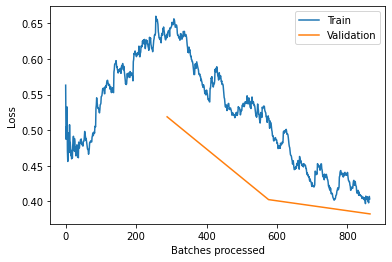

In [35]:
learn.recorder.plot_losses()

In [36]:
learn.save(model_path / f'10gnad__clas_unfreeze2')

## Train Model: Unfreeze All Layers

In [37]:
learn.unfreeze()
learn.fit_one_cycle(3, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,precision,recall,time
0,0.382982,0.379988,0.869650,0.875528,0.867462,14:10
1,0.377818,0.364620,0.874514,0.878669,0.870041,14:24
2,0.351900,0.367978,0.874514,0.878646,0.873387,13:23


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Better model found at epoch 0 with valid_loss value: 0.37998825311660767.


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Better model found at epoch 1 with valid_loss value: 0.3646202087402344.


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Loaded best saved model from /content/wandb/run-20210420_193333-1o6f3pzg/files/bestmodel.pth


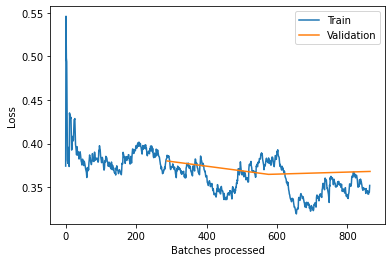

In [38]:
learn.recorder.plot_losses()

In [39]:
learn.save(model_path / f'10gnad__clas_unfreeze_all')
learn.export(model_path / f'10gnad__final.pkl')

## Evaluate Model

In [40]:
%%time
interp = ClassificationInterpretation.from_learner(learn)

CPU times: user 19.2 s, sys: 16.8 s, total: 36 s
Wall time: 36.3 s


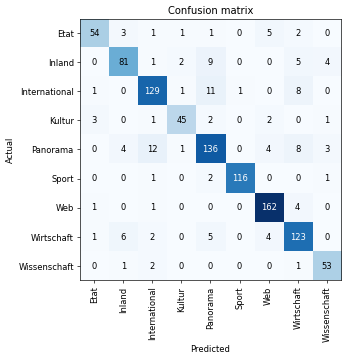

In [41]:
size = 5 + len(learn.data.classes) * 0.1
interp.plot_confusion_matrix(figsize=(size,size), dpi=60)

In [42]:
# Most Confused Categories
display(pd.DataFrame(interp.most_confused(), columns=['Actual', 'Predicted', 'count']).head(10))

,Actual,Predicted,count
0,Panorama,International,12
1,International,Panorama,11
2,Inland,Panorama,9
3,International,Wirtschaft,8
4,Panorama,Wirtschaft,8
5,Wirtschaft,Inland,6
6,Etat,Web,5
7,Inland,Wirtschaft,5
8,Wirtschaft,Panorama,5
9,Inland,Wissenschaft,4


In [43]:
df_cm = pd.DataFrame(interp.confusion_matrix(), index=data_clas.classes, columns=data_clas.classes)
sorted_labels = df_cm.sum().sort_values(ascending=False).index
df_cm = df_cm.reindex(sorted_labels)[sorted_labels]
display(df_cm)

,Web,Panorama,Wirtschaft,International,Sport,Inland,Wissenschaft,Etat,Kultur
Web,162,0,4,1,0,0,0,1,0
Panorama,4,136,8,12,0,4,3,0,1
Wirtschaft,4,5,123,2,0,6,0,1,0
International,0,11,8,129,1,0,0,1,1
Sport,0,2,0,1,116,0,1,0,0
Inland,0,9,5,1,0,81,4,0,2
Wissenschaft,0,0,1,2,0,1,53,0,0
Etat,5,1,2,1,0,3,0,54,1
Kultur,2,2,0,1,0,0,1,3,45


In [44]:
def confmat2predictions(df: pd.DataFrame) -> pd.DataFrame:
    """Extract Predictions from a Confusion Matrix"""
    df_stacked = df.stack()
    return pd.DataFrame(list(df_stacked.index.to_series().repeat(df_stacked).values), columns=['true', 'pred'])

In [45]:
preds = confmat2predictions(df_cm)
print(skm.classification_report(preds.true, preds.pred, labels=df_cm.index))

               precision    recall  f1-score   support

          Web       0.92      0.96      0.94       168
     Panorama       0.82      0.81      0.81       168
   Wirtschaft       0.81      0.87      0.84       141
International       0.86      0.85      0.86       151
        Sport       0.99      0.97      0.98       120
       Inland       0.85      0.79      0.82       102
 Wissenschaft       0.85      0.93      0.89        57
         Etat       0.90      0.81      0.85        67
       Kultur       0.90      0.83      0.87        54

     accuracy                           0.87      1028
    macro avg       0.88      0.87      0.87      1028
 weighted avg       0.88      0.87      0.87      1028

